## 04_PyTorch_Custom_Datasets Creation Tutorial

---



We have used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via : custom datasets.

## Domain Libraries

Depending on what we are working on, vision, text, audio, recommendation, you will want to look into each of the pytorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb



In [166]:
## 0. Importing pytorch and setting up device agnosting code
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'1.13.0+cu116'

In [167]:
# Setup device-agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, ~25 testing).

Why do this?
Ans: When starting out ML projects, its important to try things on a small scale and then increase the scale when necessary. 
The whole point is to speed up how fast you can experiment.  

In [168]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist , creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading pizza, steak and sushi data...")
    f.write(request.content)

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [169]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [170]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'. 
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'. 
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'. 
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'. 
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'. 
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'. 
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'. 


In [171]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image

Let's write some code to:

1. Get all the image paths

2. Pick a random image path using Python's random.choice()

3. Get the image class name using `Pathlib.Path.parent.stem`.

4. Since we are working with images, let us open the images with python's PIL.

5. We will then show the image and print metadata. 

In [172]:
image_path

PosixPath('data/pizza_steak_sushi')

Random Image Path: data/pizza_steak_sushi/train/pizza/3699992.jpg
Image Class : pizza
Imge height: 384
Imge height: 512


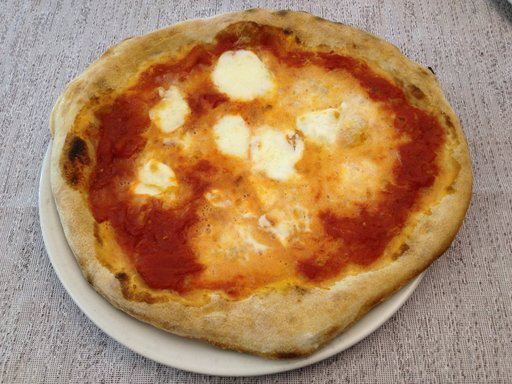

In [173]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# print(random_image_path)

# 3. Get image class from the path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# print(image_class)

# 4. Open image 
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class : {image_class}")
print(f"Imge height: {img.height}")
print(f"Imge height: {img.width}")
img

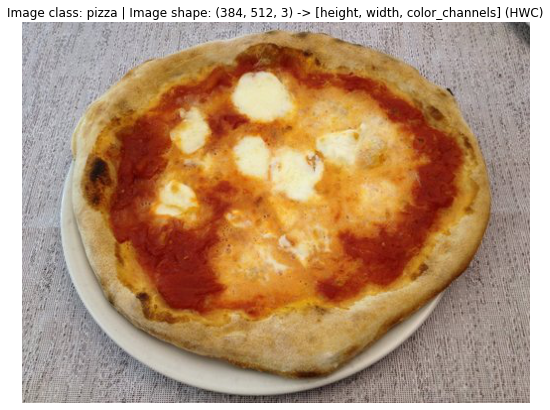

In [174]:
# Visualizing an image with matplotlib...
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

In [175]:
img_as_array

array([[[162, 165, 174],
        [130, 133, 142],
        [157, 160, 169],
        ...,
        [149, 149, 149],
        [166, 166, 166],
        [168, 170, 169]],

       [[164, 167, 176],
        [133, 136, 145],
        [161, 164, 173],
        ...,
        [131, 131, 131],
        [157, 157, 157],
        [163, 163, 163]],

       [[180, 183, 192],
        [166, 169, 178],
        [173, 176, 185],
        ...,
        [ 97,  97,  97],
        [129, 129, 129],
        [153, 153, 153]],

       ...,

       [[196, 191, 185],
        [148, 143, 137],
        [ 90,  85,  79],
        ...,
        [162, 147, 140],
        [140, 125, 118],
        [164, 149, 142]],

       [[188, 183, 177],
        [133, 128, 122],
        [ 89,  84,  78],
        ...,
        [156, 141, 134],
        [147, 132, 125],
        [153, 138, 131]],

       [[183, 178, 172],
        [154, 149, 143],
        [155, 150, 144],
        ...,
        [151, 136, 129],
        [155, 140, 133],
        [142, 127, 120]]

## 3. Transforming data

Before we can use our image data with pytorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` , we will call these `Dataset` and `DataLoader`.

In [176]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation : https://pytorch.org/vision/0.9/transforms.html?highlight=transforms

In [177]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64 x 64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.tensor
    transforms.ToTensor()
])

In [178]:
data_transform(img), data_transform(img).dtype

(tensor([[[0.6627, 0.6667, 0.6549,  ..., 0.4118, 0.2980, 0.3137],
          [0.6784, 0.6706, 0.6627,  ..., 0.4980, 0.3569, 0.2784],
          [0.6667, 0.6745, 0.6667,  ..., 0.5843, 0.4588, 0.3216],
          ...,
          [0.6353, 0.6314, 0.6471,  ..., 0.6157, 0.6196, 0.6353],
          [0.6314, 0.6353, 0.6588,  ..., 0.6078, 0.6000, 0.6196],
          [0.6275, 0.6353, 0.6549,  ..., 0.5922, 0.5765, 0.6039]],
 
         [[0.6706, 0.6667, 0.6588,  ..., 0.4039, 0.2941, 0.3098],
          [0.6863, 0.6706, 0.6667,  ..., 0.4745, 0.3412, 0.2745],
          [0.6706, 0.6745, 0.6706,  ..., 0.5451, 0.4314, 0.3059],
          ...,
          [0.6157, 0.6078, 0.6196,  ..., 0.5608, 0.5647, 0.5804],
          [0.6118, 0.6157, 0.6353,  ..., 0.5569, 0.5451, 0.5608],
          [0.6078, 0.6118, 0.6314,  ..., 0.5412, 0.5176, 0.5451]],
 
         [[0.7059, 0.6941, 0.6824,  ..., 0.3961, 0.2902, 0.3059],
          [0.7216, 0.7020, 0.6980,  ..., 0.4549, 0.3333, 0.2627],
          [0.7020, 0.7059, 0.7020,  ...,

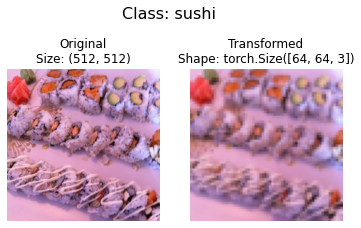

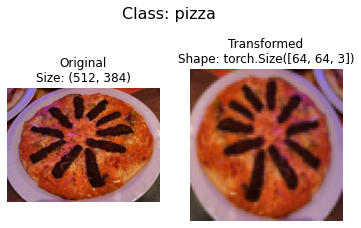

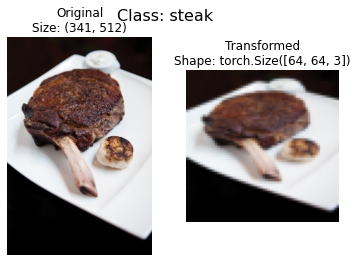

In [179]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and 
    loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis('off')

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [180]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform = None) # a transform for the label

test_data = datasets.ImageFolder(root= test_dir,
                                  transform=data_transform) # a transform for the data
                                  
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [181]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [182]:
# GEt class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [183]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [184]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [185]:
# Index on the train_data dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

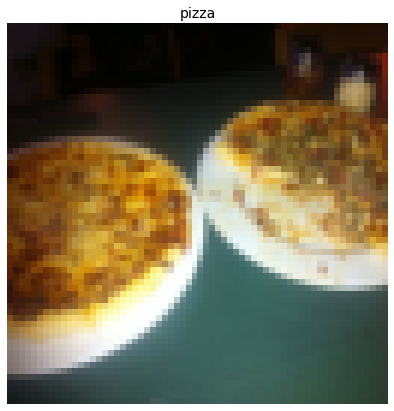

In [186]:
# Rearrange the order of dimensions 
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoader's`  

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time. 

In [187]:
import os
os.cpu_count()

2

In [188]:
# turn train and test datasets into dataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True) 

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f45dc345cd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f45dc345c40>)

In [189]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [190]:
len(train_data), len(test_data)

(225, 75)

In [191]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like 
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file.

2. Want to be able to get class names from the dataset.

3. Want to be able to get classes as dictionary from the Dataset.

Pros: 

* Can Create a `Dataset` out of almost anything.
* Not limited to PyTorch pre-built `Dataset` functions

Cons:

* Even though you could create a `Dataset` out of almost anything, it does not mean it will work....
* Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues.  

All custom datasets in PyTorch, often subclass - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [192]:
import os
import pathlib 
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [193]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format). 

2. Raise an error if the class names are not found (if this happens, there might be something wrong with the directory structure).

3. Turn the class names into a dict and a list and return them.


In [194]:
# Setup path for target directory
target_directory = train_dir
print(f"target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [195]:
list(os.scandir(target_directory))

[<DirEntry 'steak'>, <DirEntry 'sushi'>, <DirEntry 'pizza'>]

In [196]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """ Finds the class folder names in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}...please check file structure.")
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [197]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to :

1. Subclass `torch.utils.data.Dataset`

2. Init our subclass with a target directory (the directory we would like to get data from) as well as a transform if we would like to transform our data.

3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we would like to use 
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels

4. Create a function to `load_images()`, this function will open an image.

5. Override the `__len()__` method to return the length of our dataset. 

6. Override the `__getitem()__` method to return a given sample when passed an index.

In [198]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                 targ_dir: str, 
                 transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms 
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a pathand returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    #5. Overwrite __len()__
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)

    #6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [199]:
# Create a transform 
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [200]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)

In [201]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f45dbbec220>,
 <__main__.ImageFolderCustom at 0x7f45dbbec340>)

In [202]:
len(train_data), len(train_data_custom)

(225, 225)

In [203]:
len(test_data), len(test_data_custom)

(75, 75)

In [204]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [205]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [206]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images 

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.

2. To prevent the display getting out of hand, let's cap the number of images to view at 10.

3. Set the random seed for reproducibility.

4. Get a list of random sample indexes from the target dataset. 

5. Setup a matplotlib plot.

6. Loop through random sample indexes and plot them with matplotlib. 

7. Make sure the dimensions of our images line up with matplotlib (HWC).

In [207]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n should not be larger than 10, setting to 10 and removing shape display.")
    # 3. Set the seed
    if seed:
        random.seed(seed)
    
    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1, 2, 0)  # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

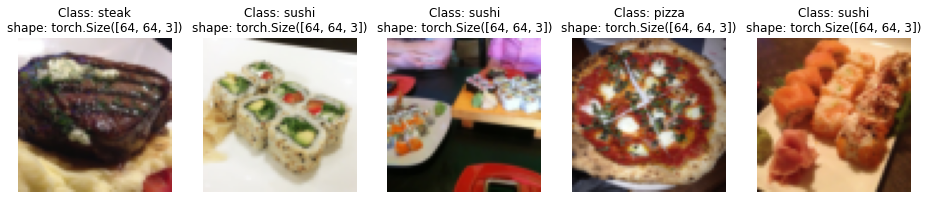

In [208]:
# Display random iamges from ImageFolder created Dataset
display_random_images(
    train_data,
    n=5,
    classes = class_names,
    seed=None
)

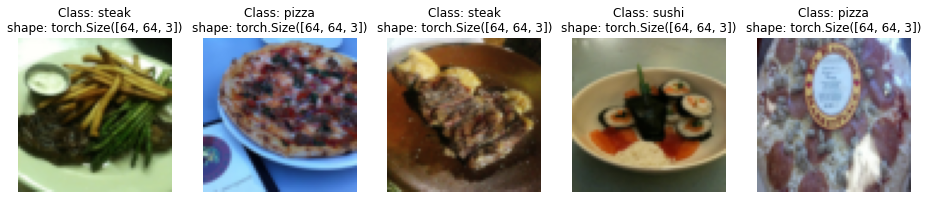

In [209]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5, 
                      classes = class_names,
                      seed=None)

### 5.4 Turn Custom Loaded Images into `DataLoader`


In [210]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f45dbd3fd60>,
 <torch.utils.data.dataloader.DataLoader at 0x7f45dbda5eb0>)

In [211]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

Data Augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to training images. 

This practice hopefully results in a model that's more generalizable to unseen data. 

Let's take a look at one particular type of data augmentation used to train pytorch vision models to state-of-the-art levels... 

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [212]:
# Let's look at TrivialAugment - https://pytorch.org/vision/stable/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [213]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg')]

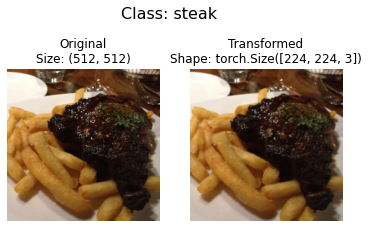

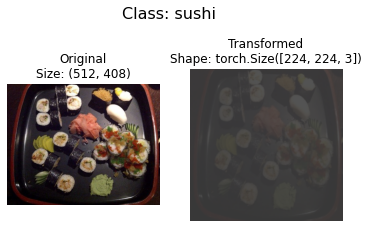

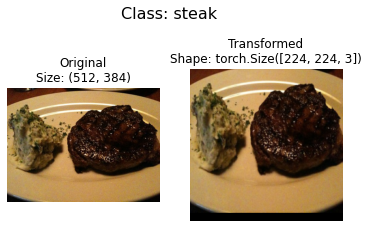

In [214]:
# Plot random images
plot_transformed_images(
    image_paths = image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without Data Augmentation

Let's replicate TinyVGG architecture from the CNN Explainer Website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [215]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [216]:
# 1. Load and Transform Data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle=False)

### 7.2 Create TinyVGG model class 

In [217]:
class TinyVGG(nn.Module):
    """
    Model Architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion (speeding up operations behind the scenes): https://horace.io/brrr_intro.html


In [218]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data (3 for RGB)
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Use torchinfo to get an idea of the shapes going through our model

In [219]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [220]:
# Try forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6318e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5022e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8256e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### 7.4 Use torchinfo to get an idea of the shapes going through our model

In [221]:
# Install torchinfo, import if its available
try:
    import torchinfo
except: 
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.

* `test_step()` - takes in a model and dataloader and evaluate the model on the dataloader.

In [222]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device= device):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    #Loop through data_loader data batches
    for batch, (X,y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)  # output model logits

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get the average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [223]:
# Create test_step()
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device= device):
    
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        #Loop through data_loader data batches
        for batch, (X,y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)  # output model logits

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate accuracy metric
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get the average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [224]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloder + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs 
    return results

### 7.7 Train and evaluate model 0

In [225]:
# Set random seed (for educational purposes)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print how long it took 
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1063 | Train Acc: 0.3047 | Test Loss: 1.0956 | Test Acc: 0.5703
Epoch: 1 | Train Loss: 1.0835 | Train Acc: 0.4453 | Test Loss: 1.0805 | Test Acc: 0.4023
Epoch: 2 | Train Loss: 1.1041 | Train Acc: 0.2812 | Test Loss: 1.0687 | Test Acc: 0.4023
Epoch: 3 | Train Loss: 1.0752 | Train Acc: 0.4805 | Test Loss: 1.0518 | Test Acc: 0.5234
Epoch: 4 | Train Loss: 1.0637 | Train Acc: 0.3945 | Test Loss: 1.0388 | Test Acc: 0.3984
Epoch: 5 | Train Loss: 0.9952 | Train Acc: 0.5820 | Test Loss: 0.9993 | Test Acc: 0.4883
Epoch: 6 | Train Loss: 0.8921 | Train Acc: 0.5703 | Test Loss: 0.8457 | Test Acc: 0.5781
Epoch: 7 | Train Loss: 0.9429 | Train Acc: 0.4688 | Test Loss: 0.8988 | Test Acc: 0.4727
Epoch: 8 | Train Loss: 0.9020 | Train Acc: 0.5195 | Test Loss: 0.9363 | Test Acc: 0.5273
Epoch: 9 | Train Loss: 0.8090 | Train Acc: 0.6211 | Test Loss: 0.8131 | Test Acc: 0.6250
Epoch: 10 | Train Loss: 0.8987 | Train Acc: 0.5352 | Test Loss: 0.8193 | Test Acc: 0.6836
Epoch: 11 | Train Lo

In [226]:
model_0_results

{'train_loss': [1.1063424497842789,
  1.083478420972824,
  1.104142427444458,
  1.0751738101243973,
  1.0637297183275223,
  0.9952033534646034,
  0.8921109475195408,
  0.9429499953985214,
  0.9020004197955132,
  0.8090350329875946,
  0.898719996213913,
  0.8196801617741585,
  0.7923429869115353,
  0.739298976957798,
  0.737933436408639,
  0.82396350055933,
  0.7675234153866768,
  0.7557946108281612,
  0.6761684492230415,
  0.685266450047493],
 'train_acc': [0.3046875,
  0.4453125,
  0.28125,
  0.48046875,
  0.39453125,
  0.58203125,
  0.5703125,
  0.46875,
  0.51953125,
  0.62109375,
  0.53515625,
  0.671875,
  0.62890625,
  0.67578125,
  0.69140625,
  0.55078125,
  0.7109375,
  0.67578125,
  0.7265625,
  0.71484375],
 'test_loss': [1.0955626368522644,
  1.0805057883262634,
  1.0687271878123283,
  1.051848717033863,
  1.038834884762764,
  0.9993427097797394,
  0.8457400389015675,
  0.8987656682729721,
  0.9363113641738892,
  0.8130801096558571,
  0.8193226382136345,
  0.876978576183319

### 7.8 Plot the Loss Curves of model 0

A **loss curve** is a way of thinking your model's progress over time.

A good guide for different loss curves can be seen here: https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

In [227]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [228]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """ Plot training curves of results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize=(15,7))

    # PLot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();

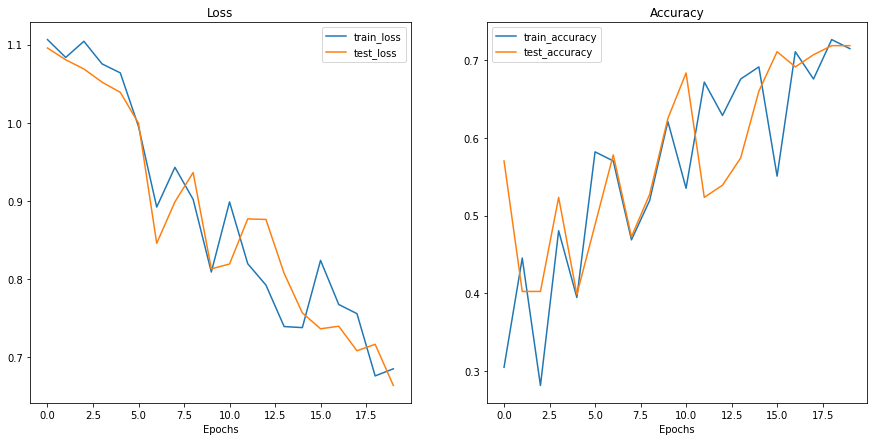

In [229]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

A Loss Curve is one of the most helpful ways to troubleshoot a model. 

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before with some data augmentation. 


### 9.1 Create transform with data augmentation

In [230]:
# Create training transform with TrivialAugment
from torchvision import transforms

train_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

## 9.2 Create train and test `Dataset's` and `DataLoader's` with data augmentation

In [231]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform = train_transforms_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform = test_transforms_simple)

In [232]:
# Turn our datasets into DataLoaders 
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and Train Model 1

This time we will be using the same model architecture except this time we have augmented the training data.

In [233]:
# Create model_1 and send it to the target device

# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

Now we have a model and dataloaders, let's create a loss function and optimizer and call upon our `train()` function to evaluate our model. 

In [234]:
# Set random seed (for educational purposes)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print how long it took 
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1049 | Train Acc: 0.2500 | Test Loss: 1.0937 | Test Acc: 0.4258
Epoch: 1 | Train Loss: 1.0794 | Train Acc: 0.4258 | Test Loss: 1.0762 | Test Acc: 0.4258
Epoch: 2 | Train Loss: 1.1276 | Train Acc: 0.3047 | Test Loss: 1.1211 | Test Acc: 0.3047
Epoch: 3 | Train Loss: 1.0820 | Train Acc: 0.4258 | Test Loss: 1.1010 | Test Acc: 0.3047
Epoch: 4 | Train Loss: 1.1024 | Train Acc: 0.3047 | Test Loss: 1.0904 | Test Acc: 0.3047
Epoch: 5 | Train Loss: 1.1116 | Train Acc: 0.3867 | Test Loss: 1.0791 | Test Acc: 0.4258
Epoch: 6 | Train Loss: 1.0770 | Train Acc: 0.4297 | Test Loss: 1.0777 | Test Acc: 0.5469
Epoch: 7 | Train Loss: 1.0714 | Train Acc: 0.3750 | Test Loss: 1.0638 | Test Acc: 0.3281
Epoch: 8 | Train Loss: 1.0609 | Train Acc: 0.3242 | Test Loss: 1.0384 | Test Acc: 0.5703
Epoch: 9 | Train Loss: 1.0593 | Train Acc: 0.3516 | Test Loss: 1.0258 | Test Acc: 0.4648
Epoch: 10 | Train Loss: 1.0569 | Train Acc: 0.3633 | Test Loss: 1.0134 | Test Acc: 0.5117
Epoch: 11 | Train Lo

In [235]:
model_1_results

{'train_loss': [1.1049089431762695,
  1.0793896168470383,
  1.1275624334812164,
  1.0820195749402046,
  1.1023673117160797,
  1.1116149872541428,
  1.0769992619752884,
  1.0714402198791504,
  1.0609045177698135,
  1.0593274980783463,
  1.056921012699604,
  1.0493657514452934,
  1.060791052877903,
  0.9850724190473557,
  0.9982224628329277,
  1.0736640989780426,
  0.9602554589509964,
  1.0836337804794312,
  1.0142968073487282,
  0.9766776859760284],
 'train_acc': [0.25,
  0.42578125,
  0.3046875,
  0.42578125,
  0.3046875,
  0.38671875,
  0.4296875,
  0.375,
  0.32421875,
  0.3515625,
  0.36328125,
  0.42578125,
  0.44140625,
  0.50390625,
  0.42578125,
  0.390625,
  0.5546875,
  0.359375,
  0.53125,
  0.62109375],
 'test_loss': [1.0937318950891495,
  1.0761659294366837,
  1.1211110204458237,
  1.1009567081928253,
  1.0904235392808914,
  1.0790545642375946,
  1.0776943117380142,
  1.0638323724269867,
  1.0383626818656921,
  1.0257735326886177,
  1.0133768543601036,
  0.9854157119989395,

### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your model's performance overtime. 

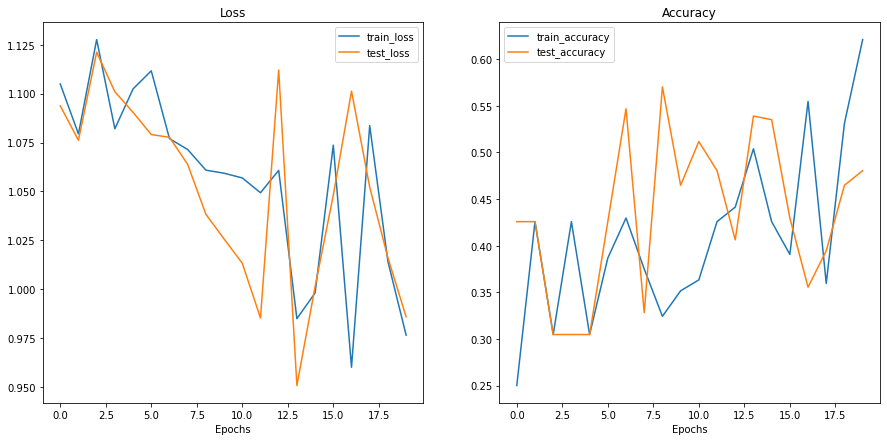

In [236]:
plot_loss_curves(model_1_results)

## 10. Compare model results 

After evaluating our modelling experiments on their own, its important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we are data)

2. PyTorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html

3. Ml Flow: https://mlflow.org/

4. Weights and Biases: https://wandb.ai/site

In [237]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df[:5], model_1_df[:5]

(   train_loss  train_acc  test_loss  test_acc
 0    1.106342   0.304688   1.095563  0.570312
 1    1.083478   0.445312   1.080506  0.402344
 2    1.104142   0.281250   1.068727  0.402344
 3    1.075174   0.480469   1.051849  0.523438
 4    1.063730   0.394531   1.038835  0.398438,
    train_loss  train_acc  test_loss  test_acc
 0    1.104909   0.250000   1.093732  0.425781
 1    1.079390   0.425781   1.076166  0.425781
 2    1.127562   0.304688   1.121111  0.304688
 3    1.082020   0.425781   1.100957  0.304688
 4    1.102367   0.304688   1.090424  0.304688)

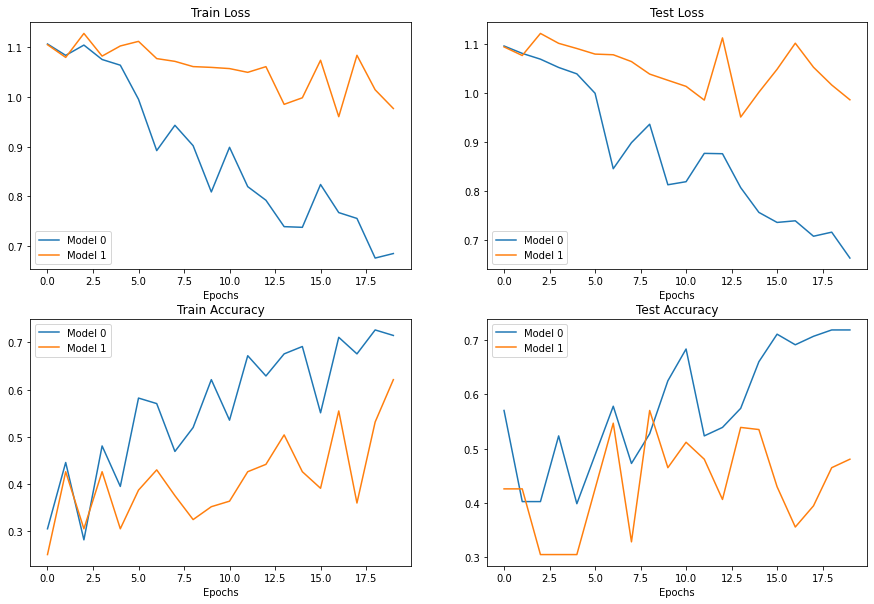

In [238]:
# Setup a plot 
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Making a prediction on a custom image

Although we have trained a model on custom data... how do you make a prediction on a sample/image that is not either in training or testing dataset.

In [239]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza_slice.jpeg"

# Download the image if it does not already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://img.freepik.com/free-photo/slice-fresh-pizza-with-pepperoni-white_144627-24389.jpg")
        print(f"Downloading {custom_image_path}....")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download....")

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype (float32)
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch using - https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [242]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]]], dtype=torch.uint8)

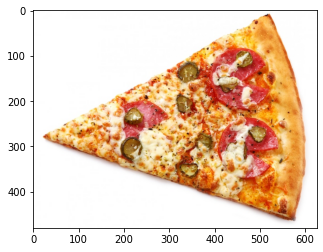

In [243]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [245]:
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype; {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]],

        [[255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         ...,
         [254, 254, 255,  ..., 255, 255, 255],
         [254, 254, 255,  ..., 255, 254, 254],
         [254, 254, 255,  ..., 255, 254, 254]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 480, 626])
Custom image dataty

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [246]:
# # Try to make a prediction on an image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image_uint8.to(device)) # RuntimeError: Input type (unsigned char) and bias type (float) should be the same

RuntimeError: ignored

In [250]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 0.9961],
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 0.9961]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 0.9961],
         [0.9961, 0.9961, 1.0000,  ..., 1.0000, 0.9961, 0.9961]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

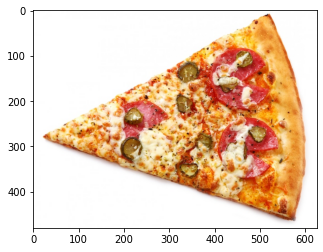

In [251]:
plt.imshow(custom_image.permute(1, 2, 0))

In [253]:
# Create a transform pipeline to resize the image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape} | Transformed image shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 480, 626]) | Transformed image shape: torch.Size([3, 64, 64])


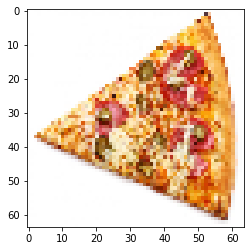

In [256]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [258]:
# Making a prediction on the transformed custom image
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor.
* Make sure the images was the same datatype as the model (torch.float32).
* Make sure the image was in the same shape the model was trained on (3X64x64) with a batch size (1, 3, 64, 64).
* Make sure the image was on the same device as our model.

In [262]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.5206, 0.1859, 0.2934]])

In [265]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred, dim=1).cpu()
custom_image_pred_labels

tensor([0])

In [266]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom iamge prediction together: building a function

Ideal outcome: 

A function where we pass an image path to and have our model predict on that image and plot the image + prediction

In [273]:
def custom_image_prediction_and_plotting(model: torch.nn.Module,
                                        image_path: str,
                                        class_names: List[str] = None,
                                        transform=None,
                                        device=device):
    '''
    Makes a prediction on a target image with a trained model and plots images and prediction.
    '''
    # Load in the image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0,1]
    target_image = target_image / 255.
    
    # Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # Make sure the model is on the target device
    model.to(device)

    # Turn on eval/inference mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension (this is the batch dimension, e.g. our model will be predicting on batches of 1x images)
        target_image = target_image.unsqueeze(0)

        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device)) # make sure the target image is on the right device

    # Conver the logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert the prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction proabability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # removes batch dimension and rearrange shape to the HWC format

    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis('off')

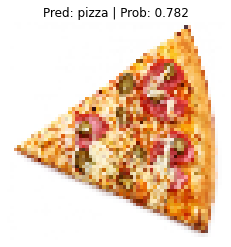

In [274]:
# Pred on custom image
custom_image_prediction_and_plotting(model=model_0,
                                     image_path=custom_image_path,
                                     class_names=class_names,
                                     transform = custom_image_transform,
                                     device=device)

## Exercises 

For all exercises and curriculum, see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#exercises
